<a href="https://colab.research.google.com/github/FelipeErmeson/credit-card-fraud-detection/blob/main/Deteccao_de_Fraude_em_Cartoes_de_Credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="30%" src="https://raw.githubusercontent.com/FelipeErmeson/Data-Science-Projects/b35dcf53814c50c86f65de7628483151404026a7/logotipo.svg">

*by [Felipe Lima](https://www.linkedin.com/in/felipe-ermeson-b484bb128/)*

---

# **Detecção de Fraudes em Cartões de Crédito**

Neste projeto iremos construir um modelo de machine learning, que irá prever se a transação é fraudulenta ou não.

Esse é um problema que apresenta alguns **desafios**, no mundo real apesar dos golpes financeiros estarem aumentando, ainda sim existem mais transações normais do que as transações fraudulentas, caracterizando um problema de desbalanceamento da nossa variável alvo.

Outro desafio são os dados em sí, já que foram anônimizados e técnicas de *engenharia de features* se torna complicado já que desconhecemos as variáveis.
<p align=center>
<img src="https://images.unsplash.com/photo-1612795459707-1002f77720d2?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80" width="50%"></p>

Uma boa prática na criação de um projeto de Data Science, é a escolha antecipada de uma boa **métrica** de avaliação do modelo. Já temos conhecimento através da [análise de dados](https://github.com/FelipeErmeson/credit-card-fraud-detection/blob/main/Analise_de_Dados_de_Fraude_em_Cartoes_de_Credito.ipynb) realizada, que os dados estão desbalanceados, portanto a acurácia se torna uma métrica ruim. A métrica **F1-score** e **AUPRC** são boas métricas para dar uma atenção melhor no recall e precision.


## **Importando os Dados e bibliotecas necessárias**

Os dados que usaremos neste projeto foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

As variáveis passaram por uma transformação conhecida como **Análise de Componentes Principais** (*Principal Component Analysis* - PCA), onde permite a redução da dimensionalidade, prezervando a maior quantidade de informações possíveis dos recursos. As novas variáveis são chamadas de **componentes**.


In [1]:
# biblioteca responsável por criar dados sintéticos
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install xgboost==1.6.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 255.9 MB 43 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 6.9 MB/s 


In [4]:
import xgboost
xgboost.__version__

'1.6.2'

In [5]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import random
from scipy.stats import loguniform, uniform, randint


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from skopt import BayesSearchCV

from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, recall_score, f1_score, classification_report, roc_auc_score, average_precision_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

O dataset irei pegar de um link direto ao `csv` no dropbox, mas pode ser facilmente [baixado](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) no Kaggle.

In [6]:
# importar os dados para um dataframe
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

df = pd.read_csv(file_path)
df.shape

(284807, 31)

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## **Preparação dos Dados**

* Optarei por não normalizar o recurso **Amount**, pois utilizaremos modelos baseados em árvores de decisão.
* O recurso **Time** não contribui para a modelagem do fenômeno.
* Iremos realizar a divisão do conjunto de dados entre **treino**, **validação** (utilizado para realizar ajustes) e **teste** (dados para avaliação final da generalização do modelo).
* Para a performance do modelo não ser prejudicado pelo desbalanceamento dos dados, iremos balancear os dados criando **dados sintéticos** para a nossa classe minoritária (fraude).
* Como uma alternativa a criação de dados sintéticos, iremos utilizar pesos maiores para os erros da classe **minoritária**.
* Também iremos **remover os dados duplicados** que existem no dataset.

In [9]:
df[df.duplicated()].index

Int64Index([    33,     35,    113,    114,    115,    221,    223,   1178,
              1180,   1382,
            ...
            282210, 282211, 282212, 282213, 282985, 282987, 283483, 283485,
            284191, 284193],
           dtype='int64', length=1081)

In [10]:
df[df.duplicated()].Class.value_counts()

0    1062
1      19
Name: Class, dtype: int64

In [11]:
df.drop(df[df.duplicated()].index, inplace=True)
df.shape

(283726, 31)

In [12]:
# setando a semente para reprodução dos resultados
SEED = 14
np.random.seed(SEED)
np.random.RandomState(SEED)
random.seed(SEED)

## **Divisão dos dados de treinamento e teste**

Note que os dados de **validação** serão extraídos da base de treinamento, a fim de que a avaliação final não seja **contaminada** com a base de teste.

Os dados de teste representam 10% de todos os dados. E a distribuição da classe alvo de teste está estratificada (representa a mesma do treinamento).

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class', 'Time'], axis=1), df.Class, test_size=0.1, random_state=SEED, stratify=df.Class)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train.value_counts())
print(y_test.value_counts())

(255353, 29)
(28373, 29)
(255353,)
(28373,)
0    254927
1       426
Name: Class, dtype: int64
0    28326
1       47
Name: Class, dtype: int64


## **Validação Cruzada**
Optei por realizar uma validação cruzada no dataset de treinamento, para escolher o melhor conjunto de hiperparâmetros do modelo. Ao setar `oversampling=True` irá realizar o oversampling para a classe minoritária apenas no conjunto de treinamento e a validação sem o oversampling para evitar `vazamento de dados`, porém deixar uma penalidade maior para a classe minoritária se mostrou levemente melhor.

In [14]:
params = {'n_splits_outer': 10,
          'n_splits_inner': 5,
          'n_iter': 20,
          'scoring': 'f1',
          'oversampling': False,
          'shuffle': True,
          'seed': SEED
          }

In [15]:
from skopt.space.space import Categorical, Integer, Real
model_xgb = xgboost.XGBClassifier(objective = 'binary:logistic', tree_method = "gpu_hist", random_state=params['seed'], n_jobs=-1)

param_dist = {'n_estimators': Integer(800, 1200),
              'learning_rate': Real(0.001, 0.2, 'log-uniform'),
              'subsample': Real(0.01, 1.0, 'uniform'), # fração de exemplos a serem amostradas aleatoriamente para cada árvore
              'max_depth': Integer(2, 8), # profundidade da árvore
              'colsample_bytree': Real(0.01, 1.0, 'uniform'), # fração de colunas amostradas aleatoriamente para cada árvore
              'min_child_weight': Real(0.2, 0.8),
              'colsample_bylevel': Real(0.01, 1.0, 'uniform'),
              'reg_lambda': Real(0.1, 1000, 'log-uniform'), # regularização L2
              'reg_alpha': (1e-9, 1.0, 'log-uniform'),
              'gamma': Real(1e-9, 10.0, 'log-uniform'),
              'max_delta_step': (0, 20),
              'scale_pos_weight': Real(50, 1000, 'log-uniform')
             }

In [25]:
def cross_validate(modelo, space, X, y, params):
  kfold_outer = KFold(n_splits=params['n_splits_outer'], shuffle=params['shuffle'], random_state=params['seed'])
  pr_splits = []
  auprc_splits = []

  for idx, (idx_train, idx_valid) in tqdm(enumerate(kfold_outer.split(X))):
    X_split_train = X.iloc[idx_train, :]
    y_split_train = y.iloc[idx_train]

    X_split_valid = X.iloc[idx_valid, :]
    y_split_valid = y.iloc[idx_valid]

    kfold_inner = KFold(n_splits=params['n_splits_inner'], shuffle=params['shuffle'], random_state=params['seed'])

    if params['oversampling']:
      sm = SMOTE(sampling_strategy='minority', random_state=params['seed'])
      X_split_train, y_split_train = sm.fit_resample(X_split_train, y_split_train)
    
    # scale_pos_weight = sum(y_split_train==0) / sum(y_split_train==1)
    # sum(negative instances) / sum(positive instances) positive referece a classe minoritária

    search_model = BayesSearchCV(
        estimator = modelo,
        search_spaces = space,    
        scoring = params['scoring'],
        cv = kfold_inner,
        n_jobs = -1,
        n_iter = params['n_iter'],   
        verbose = 0,
        refit = True,
        random_state = params['seed'])
    # search_model = RandomizedSearchCV(modelo, space, n_iter=params['n_iter'],#20,
    #                         n_jobs=-1, verbose=0, cv=kfold_inner,
    #                         scoring=params['scoring'], refit=True, random_state=params['seed'])
    
    search_model.fit(X_split_train, y_split_train.values.flatten()) # callback=status_print
    
    best_model = search_model.best_estimator_
    preds_valid = best_model.predict(X_split_valid)

    pr_split = f1_score(y_split_valid, preds_valid)
    auprc_split = average_precision_score(y_split_valid, preds_valid)
    
    pr_splits.append(pr_split)
    auprc_splits.append(auprc_split)
    print(f"SPLIT={idx}, F1={pr_split}, best_score={search_model.best_score_}, best_params={search_model.best_params_}")
  
  print(f'F1 Score Mean: {np.mean(pr_splits)}, STD: {np.std(pr_splits)}')
  print(f'AUPRC Score Mean: {np.mean(auprc_splits)}, STD: {np.std(auprc_splits)}')
  
  return pr_splits, auprc_splits

In [ ]:
f1_scores, auprc_scores = cross_validate(model_xgb, param_dist, X_train, y_train, params)

1it [07:07, 427.49s/it]

SPLIT=0, F1=0.8705882352941177, best_score=0.8633379947453174, best_params=OrderedDict([('colsample_bylevel', 0.6540916897300451), ('colsample_bytree', 0.9028772165341667), ('gamma', 3.548029739142176e-05), ('learning_rate', 0.032435514858380095), ('max_delta_step', 20), ('max_depth', 5), ('min_child_weight', 0.2819104303092185), ('n_estimators', 1200), ('reg_alpha', 3.2207998035348686e-05), ('reg_lambda', 6.091027483279239), ('scale_pos_weight', 75.82891069867075), ('subsample', 0.30948245985856193)])


2it [15:06, 457.64s/it]

SPLIT=1, F1=0.8571428571428572, best_score=0.8717064890977934, best_params=OrderedDict([('colsample_bylevel', 0.39958364266831525), ('colsample_bytree', 1.0), ('gamma', 3.3402635821326077e-07), ('learning_rate', 0.1863256490959697), ('max_delta_step', 0), ('max_depth', 3), ('min_child_weight', 0.8), ('n_estimators', 1037), ('reg_alpha', 9.854851225107039e-07), ('reg_lambda', 1.275283926438709), ('scale_pos_weight', 50.0), ('subsample', 1.0)])


3it [23:32, 479.77s/it]

SPLIT=2, F1=0.9166666666666667, best_score=0.861370356470921, best_params=OrderedDict([('colsample_bylevel', 0.7641570122701229), ('colsample_bytree', 0.7573242981175194), ('gamma', 7.684080965294232e-05), ('learning_rate', 0.03456864935904173), ('max_delta_step', 19), ('max_depth', 5), ('min_child_weight', 0.5998397894895641), ('n_estimators', 1189), ('reg_alpha', 2.1475323895072397e-07), ('reg_lambda', 2.042870390299508), ('scale_pos_weight', 85.91386408514931), ('subsample', 0.4911897468465251)])


4it [30:41, 459.95s/it]

SPLIT=3, F1=0.8349514563106796, best_score=0.8669022710295028, best_params=OrderedDict([('colsample_bylevel', 0.6964128513467276), ('colsample_bytree', 0.7003522606643975), ('gamma', 0.033100229218793506), ('learning_rate', 0.04020820041226057), ('max_delta_step', 20), ('max_depth', 6), ('min_child_weight', 0.37868067140057093), ('n_estimators', 1200), ('reg_alpha', 5.490647069990125e-07), ('reg_lambda', 0.6843069647257143), ('scale_pos_weight', 196.93208534267248), ('subsample', 0.20256524243990093)])


5it [37:38, 444.24s/it]

SPLIT=4, F1=0.8115942028985507, best_score=0.8737342691484766, best_params=OrderedDict([('colsample_bylevel', 0.6568593952741887), ('colsample_bytree', 0.9683471923324977), ('gamma', 3.914505901120485e-05), ('learning_rate', 0.03930489406923396), ('max_delta_step', 20), ('max_depth', 5), ('min_child_weight', 0.30137105210574106), ('n_estimators', 1200), ('reg_alpha', 0.0001377783647748207), ('reg_lambda', 6.580163997825835), ('scale_pos_weight', 62.48936024981069), ('subsample', 0.25789497030406705)])


6it [45:21, 450.62s/it]

SPLIT=5, F1=0.898876404494382, best_score=0.856825153374233, best_params=OrderedDict([('colsample_bylevel', 0.6180033052839058), ('colsample_bytree', 0.8039399726459144), ('gamma', 8.926495429666214e-06), ('learning_rate', 0.025166068248970268), ('max_delta_step', 19), ('max_depth', 5), ('min_child_weight', 0.375854307692412), ('n_estimators', 1183), ('reg_alpha', 3.046127247115309e-06), ('reg_lambda', 8.133482127784136), ('scale_pos_weight', 91.70837283032206), ('subsample', 0.4390893316778543)])


7it [53:21, 460.36s/it]

SPLIT=6, F1=0.8857142857142858, best_score=0.8592238256657238, best_params=OrderedDict([('colsample_bylevel', 0.6472205785103142), ('colsample_bytree', 0.8208852849550969), ('gamma', 9.79118507240484e-06), ('learning_rate', 0.03281942879600105), ('max_delta_step', 20), ('max_depth', 5), ('min_child_weight', 0.42891505768100735), ('n_estimators', 1200), ('reg_alpha', 0.000476382134766327), ('reg_lambda', 7.292063991956366), ('scale_pos_weight', 61.27144791810831), ('subsample', 0.3280294924201554)])


8it [59:43, 435.26s/it]

SPLIT=7, F1=0.8333333333333334, best_score=0.8707563012970368, best_params=OrderedDict([('colsample_bylevel', 0.6831225946680293), ('colsample_bytree', 0.9480973000162471), ('gamma', 9.841956417859886e-06), ('learning_rate', 0.033548123513566924), ('max_delta_step', 20), ('max_depth', 5), ('min_child_weight', 0.38044555704546346), ('n_estimators', 1200), ('reg_alpha', 3.8906139861216206e-05), ('reg_lambda', 6.258860825764495), ('scale_pos_weight', 68.26412879574445), ('subsample', 0.359136538362353)])


9it [1:06:55, 434.35s/it]

SPLIT=8, F1=0.8641975308641975, best_score=0.8643871209360231, best_params=OrderedDict([('colsample_bylevel', 0.12550679954797989), ('colsample_bytree', 0.7128127636306396), ('gamma', 0.15166642461853364), ('learning_rate', 0.034769904848113514), ('max_delta_step', 6), ('max_depth', 7), ('min_child_weight', 0.4604091654776523), ('n_estimators', 1200), ('reg_alpha', 5.2531011352475304e-05), ('reg_lambda', 0.1), ('scale_pos_weight', 347.98396126079246), ('subsample', 0.6994609861576487)])


10it [1:14:09, 444.93s/it]

SPLIT=9, F1=0.8674698795180723, best_score=0.8628677493126151, best_params=OrderedDict([('colsample_bylevel', 0.6461993360627141), ('colsample_bytree', 0.9186919850434201), ('gamma', 2.9285667454090307e-05), ('learning_rate', 0.03321221596358111), ('max_delta_step', 20), ('max_depth', 5), ('min_child_weight', 0.3158490357339192), ('n_estimators', 1200), ('reg_alpha', 5.0818398873708206e-05), ('reg_lambda', 6.506737310562721), ('scale_pos_weight', 70.71994198824697), ('subsample', 0.31827820789613886)])
F1 Score Mean: 0.8640534852237144, STD: 0.030157515158153958
AUPRC Score Mean: 0.7508449846353342, STD: 0.05141674353069922


## **Treinamento final do modelo**
Depois de descobrir o melhor conjunto de hiperparâmetros, iremos realizar o treinamento final com esses hiperparâmetros.

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=params['seed'], stratify=y_train)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(229817, 29)
(25536, 29)
(229817,)
(25536,)


In [41]:
modelo_xgboost = xgboost.XGBClassifier(objective = 'binary:logistic',
                                       tree_method = "gpu_hist",
                                       random_state = params['seed'],
                                       colsample_bylevel = 0.7641570122701229,
                                       colsample_bytree = 0.7573242981175194,
                                       gamma = 7.684080965294232e-05,
                                       learning_rate = 0.03456864935904173,
                                       max_depth = 5,
                                       min_child_weight = 0.5998397894895641,
                                       n_estimators = 1189,
                                       reg_lambda = 2.042870390299508,
                                       subsample = 0.4911897468465251,
                                       max_delta_step = 19,
                                       reg_alpha = 2.1475323895072397e-07,
                                       scale_pos_weight = 85.91386408514931,
                                       n_jobs = -1,
                                       verbosity=0,
                                       eval_metric=["error", "logloss"] #early_stopping_rounds
                                       )

In [42]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]
modelo_xgboost.fit(X_train, y_train, eval_set = eval_set)

[0]	validation_0-error:0.00372	validation_0-logloss:0.66046	validation_1-error:0.00419	validation_1-logloss:0.66050
[1]	validation_0-error:0.00115	validation_0-logloss:0.62978	validation_1-error:0.00114	validation_1-logloss:0.62977
[2]	validation_0-error:0.00091	validation_0-logloss:0.60105	validation_1-error:0.00110	validation_1-logloss:0.60103
[3]	validation_0-error:0.00086	validation_0-logloss:0.57418	validation_1-error:0.00098	validation_1-logloss:0.57420
[4]	validation_0-error:0.00076	validation_0-logloss:0.54921	validation_1-error:0.00086	validation_1-logloss:0.54924
[5]	validation_0-error:0.00081	validation_0-logloss:0.52522	validation_1-error:0.00086	validation_1-logloss:0.52525
[6]	validation_0-error:0.00086	validation_0-logloss:0.50268	validation_1-error:0.00090	validation_1-logloss:0.50269
[7]	validation_0-error:0.00074	validation_0-logloss:0.48149	validation_1-error:0.00082	validation_1-logloss:0.48147
[8]	validation_0-error:0.00074	validation_0-logloss:0.46136	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7641570122701229, colsample_bynode=1,
              colsample_bytree=0.7573242981175194, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=['error', 'logloss'],
              gamma=7.684080965294232e-05, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.03456864935904173, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=19, max_depth=5, max_leaves=0,
              min_child_weight=0.5998397894895641, missing=nan,
              monotone_constraints='()', n_estimators=1189, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=14,
              reg_alpha=2.1475323895072397e-07, reg_lambda=2.042870390299508, ...)

## **Validação no conjunto de teste**
Temos um **F1-score** de 0.87640 e um **AUPRC** de 0.77079. O **recall** para a classe de fraude de 0.83 ficou bom.

In [44]:
results = modelo_xgboost.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

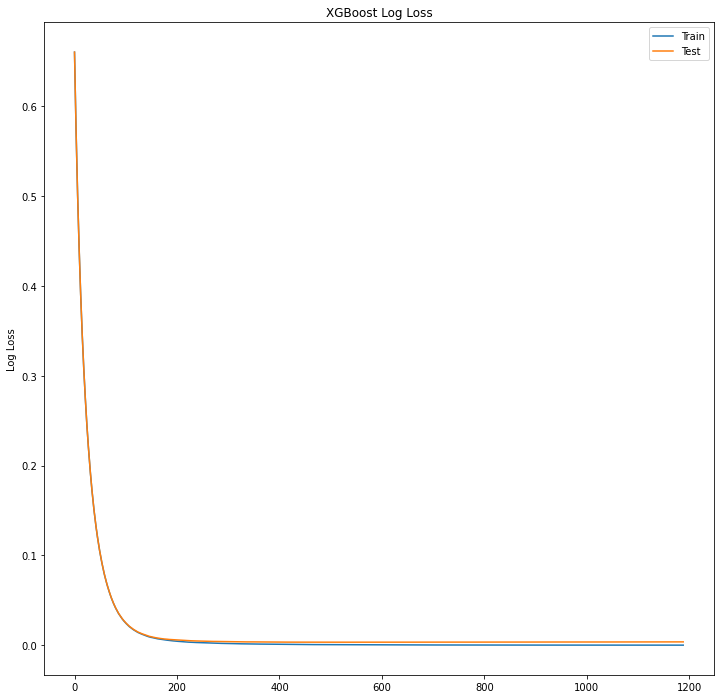

In [46]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

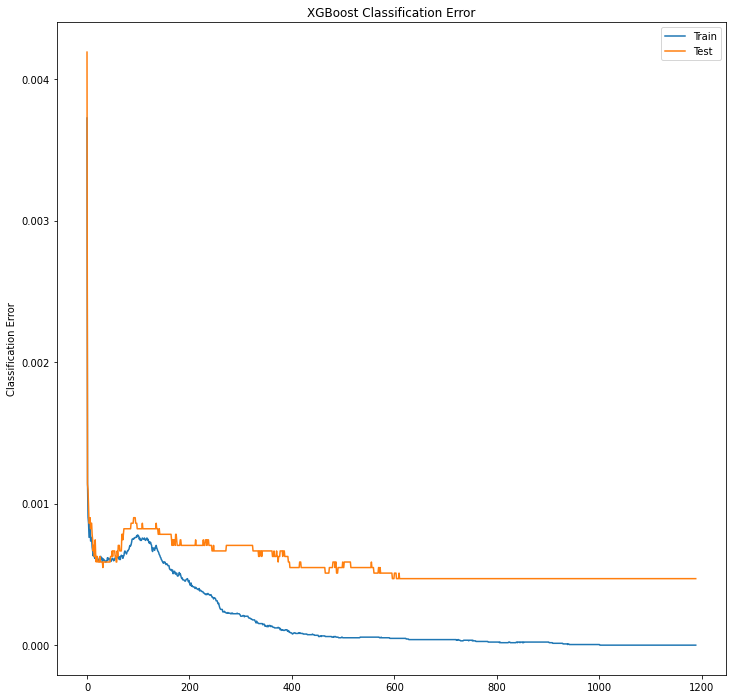

In [47]:
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

In [48]:
preds_test = modelo_xgboost.predict(X_test)
pontuacao_f1 = f1_score(y_test, preds_test)
pontuacao_auprc = average_precision_score(y_test, preds_test)
print(pontuacao_f1)
print(pontuacao_auprc)

0.8764044943820225
0.7707986755249249


In [49]:
print(classification_report(y_test, preds_test))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28326
           1       0.93      0.83      0.88        47

    accuracy                           1.00     28373
   macro avg       0.96      0.91      0.94     28373
weighted avg       1.00      1.00      1.00     28373

[[28323     3]
 [    8    39]]


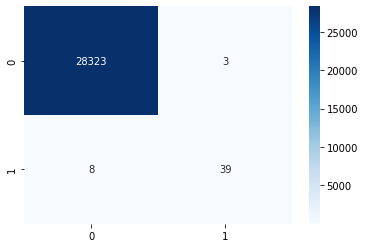

In [62]:
ax = sns.heatmap(confusion_matrix(y_test, preds_test), annot=True, cmap='Blues', fmt='.5g')

## **Considerações finais e próximos passos**

* O modelo generalizou bem, o F1-score ficou 87%. E um recall também interessante para a classe de maior interesse (fraude). 

* Testar outros tipos de modelos como o LGBM e RandomForest.

* Montar um ensemble de modelos distintos e combinar suas predições.

* Realizar um feature selection do dataset para diminuir a complexidade.

## **Referências**

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn